In [2]:
import torch
import torch_directml
dml = torch_directml.device()

In [3]:
tensor1 = torch.tensor([1]).to(dml) # Note that dml is a variable, not a string!
tensor2 = torch.tensor([2]).to(dml)

In [4]:
dml_algebra = tensor1 + tensor2
dml_algebra.item()

3

In [5]:
import os
import torch
import torchaudio
import matplotlib.pyplot as plt
from pathlib import Path

In [6]:
def load_audio_files(path: str, label:str):

    dataset = []
    walker = sorted(str(p) for p in Path(path).glob(f'*.wav'))

    for i, file_path in enumerate(walker):
        path, filename = os.path.split(file_path)
    
        # Load audio
        waveform, sample_rate = torchaudio.load(file_path)
        dataset.append([waveform, sample_rate, label])
        
    return dataset

In [7]:
import os
import re
root = '/mnt/c/Downloads/'

re_mcr = r'^rec_mcr'
re_noise = r'^rec_noise'
mcr, nothing = [],[]
for i in os.listdir(root):
    if re.search(re_mcr, i):
        mcr += load_audio_files(root+i+'/', 'microwave')
    elif re.search(re_noise, i):
        nothing += load_audio_files(root+i+'/', 'nothing')

In [8]:
print(f'Length of blender dataset: {len(mcr)}')
print(f'Length of nothing dataset: {len(nothing)}')

Length of blender dataset: 100
Length of nothing dataset: 100


In [9]:
print(len(mcr[0][0][0]))

220500


In [10]:
train_microwave = torch.utils.data.DataLoader(mcr, batch_size=1,
                                            shuffle=True, num_workers=0)
train_nothing = torch.utils.data.DataLoader(nothing, batch_size=1,
                                            shuffle=True, num_workers=0)

In [11]:
yes_waveform = mcr[0][0]
yes_sample_rate = mcr[0][1]
print(f'Yes Waveform: {yes_waveform}')
print(f'Yes Sample Rate: {yes_sample_rate}')
print(f'Yes Label: {mcr[0][2]}\n')

no_waveform = nothing[0][0]
no_sample_rate = nothing[0][1]
print(f'No Waveform: {no_waveform}')
print(f'No Sample Rate: {no_sample_rate}')
print(f'No Label: {nothing[0][2]}')

Yes Waveform: tensor([[0., 0., 0.,  ..., 0., 0., 0.]])
Yes Sample Rate: 44100
Yes Label: microwave

No Waveform: tensor([[-0.0078, -0.0078, -0.0078,  ...,  0.0000,  0.0000,  0.0000]])
No Sample Rate: 44100
No Label: nothing


In [12]:
def show_waveform(waveform, sample_rate, label):
    print("Waveform: {}\nSample rate: {}\nLabels: {} \n".format(waveform, sample_rate, label))
    new_sample_rate = sample_rate/10
   
    # Resample applies to a single channel, we resample first channel here
    channel = 0
    waveform_transformed = torchaudio.transforms.Resample(sample_rate, new_sample_rate)(waveform[channel,:].view(1,-1))

    print("Shape of transformed waveform: {}\nSample rate: {}".format(waveform_transformed.size(), new_sample_rate))

    plt.figure()
    plt.plot(waveform_transformed[0,:].numpy())

Waveform: tensor([[0., 0., 0.,  ..., 0., 0., 0.]])
Sample rate: 44100
Labels: yes 

Shape of transformed waveform: torch.Size([1, 22050])
Sample rate: 4410.0


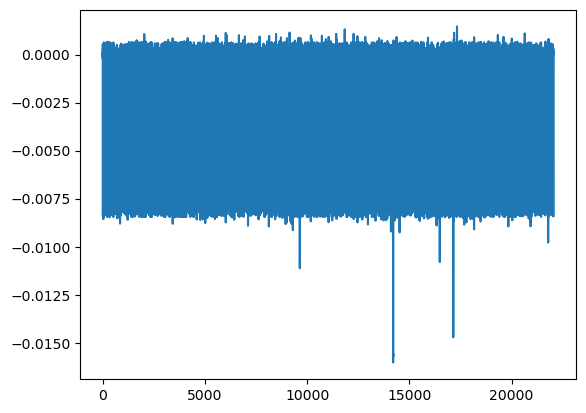

In [13]:
show_waveform(yes_waveform, yes_sample_rate, 'yes')

Waveform: tensor([[-0.0078, -0.0078, -0.0078,  ...,  0.0000,  0.0000,  0.0000]])
Sample rate: 44100
Labels: no 

Shape of transformed waveform: torch.Size([1, 22050])
Sample rate: 4410.0


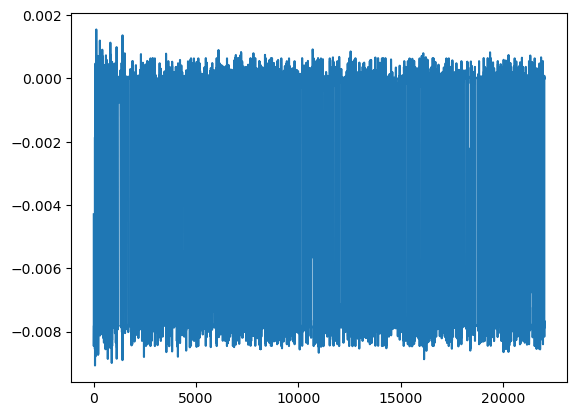

In [14]:
show_waveform(no_waveform, no_sample_rate, 'no')

In [36]:
def show_spectrogram(waveform_classA, waveform_classB):
    yes_spectrogram = torchaudio.transforms.Spectrogram()(waveform_classA)
    print("\nShape of yes spectrogram: {}".format(yes_spectrogram.size()))
    
    no_spectrogram = torchaudio.transforms.Spectrogram()(waveform_classB)
    print("Shape of no spectrogram: {}".format(no_spectrogram.size()))

    plt.figure()
    plt.subplot(1, 2, 1)
    plt.title("Features of {}".format('no'))
    plt.imshow(yes_spectrogram.log2()[0,:,:].numpy(), cmap='viridis')
    
    plt.subplot(1, 2, 2)
    plt.title("Features of {}".format('yes'))
    plt.imshow(no_spectrogram.log2()[0,:,:].numpy(), cmap='viridis')  


Shape of yes spectrogram: torch.Size([1, 201, 1103])
Shape of no spectrogram: torch.Size([1, 201, 1103])


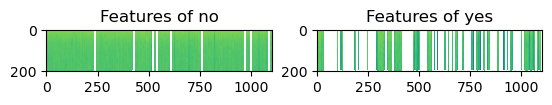

In [37]:
show_spectrogram(yes_waveform, no_waveform)

In [17]:
def show_melspectrogram(waveform,sample_rate):
    mel_spectrogram = torchaudio.transforms.MelSpectrogram(sample_rate)(waveform)
    print("Shape of spectrogram: {}".format(mel_spectrogram.size()))

    plt.figure()
    plt.imshow(mel_spectrogram.log2()[0,:,:].numpy(), cmap='viridis')

Shape of spectrogram: torch.Size([1, 128, 1103])


/home/nschdeva/anaconda3/envs/mci/lib/python3.9/site-packages/torchaudio/functional/functional.py:576: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (201) may be set too low.
  warnings.warn(


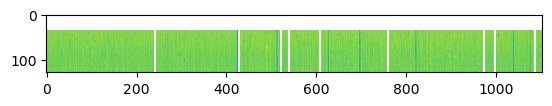

In [18]:
show_melspectrogram(yes_waveform, yes_sample_rate)

Shape of spectrogram: torch.Size([1, 128, 1103])


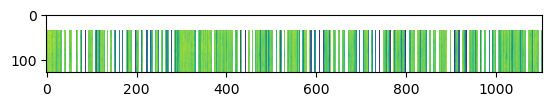

In [19]:
show_melspectrogram(no_waveform, no_sample_rate)

In [20]:
def show_mfcc(waveform,sample_rate):
    mfcc_spectrogram = torchaudio.transforms.MFCC(sample_rate= sample_rate)(waveform)
    print("Shape of spectrogram: {}".format(mfcc_spectrogram.size()))

    plt.figure()
    fig1 = plt.gcf()
    plt.imshow(mfcc_spectrogram.log2()[0,:,:].numpy(), cmap='viridis')
    
    plt.figure()
    plt.plot(mfcc_spectrogram.log2()[0,:,:].numpy())
    plt.draw()

Shape of spectrogram: torch.Size([1, 40, 1103])


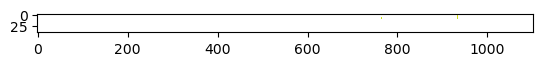

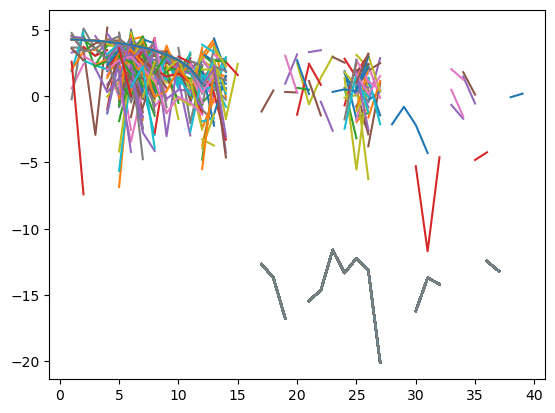

In [21]:
show_mfcc(no_waveform,  no_sample_rate)

Shape of spectrogram: torch.Size([1, 40, 1103])


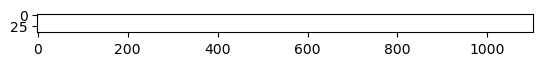

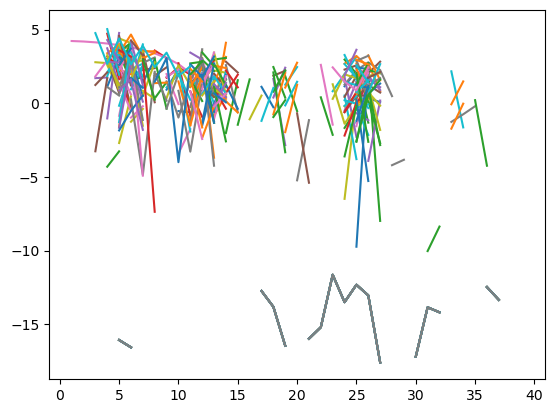

In [22]:
show_mfcc(yes_waveform,  yes_sample_rate)

In [25]:
def create_spectrogram_images(trainloader, label_dir):
    #make directory
    directory = f'./data/spectrograms/{label_dir}/'
    if(os.path.isdir(directory)):
        print("Data exists for", label_dir)
    else:
        os.makedirs(directory, mode=0o777, exist_ok=True)
        
        for i, data in enumerate(trainloader):

            waveform = data[0]
            sample_rate = data[1][0]
            label = data[2]

            # create transformed waveforms
            spectrogram_tensor = torchaudio.transforms.Spectrogram(sample_rate)(waveform)     
            
            # fig = plt.figure()
            plt.imsave(f'./data/spectrograms/{label_dir}/spec_img{i}.png', spectrogram_tensor[0].log2()[0,:,:].numpy(), cmap='viridis')

In [24]:
def create_mfcc_images(trainloader, label_dir):
    #make directory
    os.makedirs(f'./data/mfcc_spectrograms/{label_dir}/', mode=0o777, exist_ok=True)
    
    for i, data in enumerate(trainloader):

        waveform = data[0]
        sample_rate = data[1][0]
        label = data[2]
        
        mfcc_spectrogram = torchaudio.transforms.MFCC(sample_rate= sample_rate)(waveform)

        plt.figure()
        fig1 = plt.gcf()
        plt.imshow(mfcc_spectrogram[0].log2()[0,:,:].numpy(), cmap='viridis')
        plt.draw()
        fig1.savefig(f'./data/mfcc_spectrograms/{label_dir}/spec_img{i}.png', dpi=100)
 
        #spectorgram_train.append([spectrogram_tensor, label, sample_rate, ID])

In [32]:
def create_melspec_images(trainloader, label_dir):
    #make directory
    directory = f'./data/mel_spectrograms/{label_dir}/'
    if(os.path.isdir(directory)):
        print("Data exists for", label_dir)
    else:
        os.makedirs(directory, mode=0o777, exist_ok=True)
    
    for i, data in enumerate(trainloader):

        waveform = data[0]
        sample_rate = data[1][0]
        label = data[2]
        
        melspec_tensors = torchaudio.transforms.MelSpectrogram(sample_rate)(waveform)

        plt.imsave(f'./data/mel_spectrograms/{label_dir}/spec_img{i}.png', melspec_tensors[0].log2()[0,:,:].numpy(), cmap='viridis')
 
        #spectorgram_train.append([spectrogram_tensor, label, sample_rate, ID])

In [27]:
create_spectrogram_images(train_microwave, 'microwave')
create_spectrogram_images(train_nothing, 'nothing')

In [ ]:
create_mfcc_images(train_microwave, 'microwave')
create_mfcc_images(train_nothing, 'nothing')

In [33]:
create_melspec_images(train_microwave, 'microwave')
create_melspec_images(train_nothing, 'nothing')

Data exists for microwave


/home/nschdeva/anaconda3/envs/mci/lib/python3.9/site-packages/matplotlib/colors.py:1370: RuntimeWarning: invalid value encountered in subtract
  resdat -= vmin
/home/nschdeva/anaconda3/envs/mci/lib/python3.9/site-packages/matplotlib/colors.py:1371: RuntimeWarning: invalid value encountered in divide
  resdat /= (vmax - vmin)
